<h3><b>Table of contents</b></h3>

1. Introduction: Business Problem
2. Data Requirements
3. Methodology
4. Analysis
5. Results
6. Discussion
7. Conclusion

<h2><b>Introduction: Business Problem.</b></h2>

This project deals with discussing the neighborhoods of <b> Chennai, The Detroit of India</b>. This project would specifically help Business people planning to start <b>Restaurants, Hotels, etc </b>. in Chennai, Tamil Nadu, India.

The <b>Foursquare API</b> is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the <b>   k-means clustering algorithm </b> is used to achieve the task. The optimal number of clusters can be obtained using <b> silhouette score. Folium visualization library </b> can be used to visualize the clusters superimposed on the map of Chennai city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

<b>Import the required libraries. </b>

In [1]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


<h3><b>Data Requirements .</b></h3>

Chennai has multiple neighborhoods. Lets use the following dataset which has the list of locations in chennai along with their Latitude and Longitude:

https://chennaiiq.com/chennai/latitude_longitude_areas.asp

But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. First,. lets access the html file.

In [2]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of 200 means that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access.

In [3]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, chennai_data.

<b>Data Collection:</b>

In [4]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


<b>Convert Degrees Minute Seconds to Decimal Degrees.</b>

There are a total of 105 neighborhoods. But as said earlier the Latitude and Longitude data needs to be converted Degrees Minute Seconds to Decimal Degrees. The dms2dd fucntion defined below will solve this problem.

In [5]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Chennai. The latitude and longitude of chennai can be obtained using the Geolocator library.

In [6]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


<b>Chennai Map:</b>

In [8]:
# create map of Toronto using latitude and longitude values
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map

<b>Chennai Map with the neighborhoods superimposed on top:</b>

In [9]:
# add neighborhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

<b>Define Foursquare Credentials and Version.</b>

In [10]:
CLIENT_ID = '0UIQC4X0V003NCE4WXXXBIJ3SP5VK14OY5KJ2KXPAOUNPM42' # your Foursquare ID
CLIENT_SECRET = 'WKD5ZUULSGQGYJZG0AJKHLVZ5G3BEJWZTHK4UOB1DPLRJP2R' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

<b> Explore neighborhoods in Chennai. </b>

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Lets use the above function on the chennai_data neighborhoods dataframe and store the venues data returned in the chennai_venues pandas dataframe.

In [12]:
chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1034, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Debot,12.997222,80.256944,Subway,12.999040,80.254743,Sandwich Place


In [13]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,5,5,5,5,5,5
Adyar Bus Debot,12,12,12,12,12,12
Adyar Signal,26,26,26,26,26,26
Alandur,10,10,10,10,10,10
Ambattur,1,1,1,1,1,1
Anna Arch,17,17,17,17,17,17
Anna Nagar Roundana,19,19,19,19,19,19
Anna Nagar West Terminus,9,9,9,9,9,9
Anna Statue,10,10,10,10,10,10


From the above dataframe we can see that Taj Coromandal returned the highest number of venues i.e. 50. Now lets check the unique categories of all the venues returned.

In [14]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 132 uniques categories.


<h2><b>Methodology.</b></h2>

Now, we have the neighborhoods data of <b>chennai (105 neighborhoods).</b> We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of <b>1034 venues</b> have been obtained in the whole city and <b>132 unique categories.</b> But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the <b> neighborhoods with more than 10 venues.</b>

We can perform one hot encoding on the obtained data set and use it find the <b>10 most common venue category</b> in each neighborhood. Then clustering can be performed on the dataset. Here <b> K - Nearest Neighbor clustering </b>technique have been used. To find the optimal number of clusters <b>silhouette score</b> metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

<h2><b>Analysis .</b></h2>

First, lets visualize the number of venues obtained in all the neighborhoods of Chennai.

<AxesSubplot:xlabel='Neighborhood'>

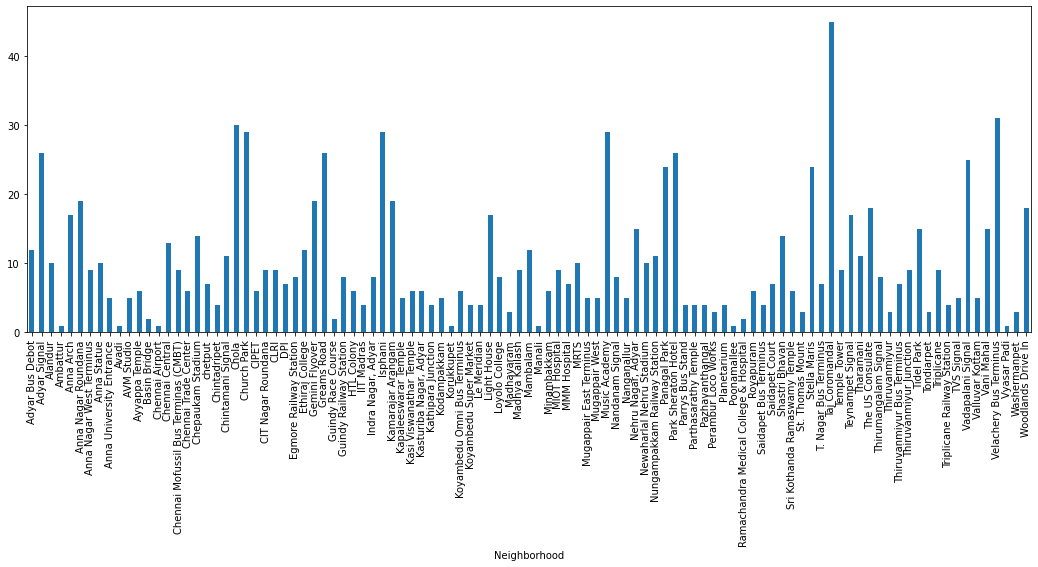

In [15]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

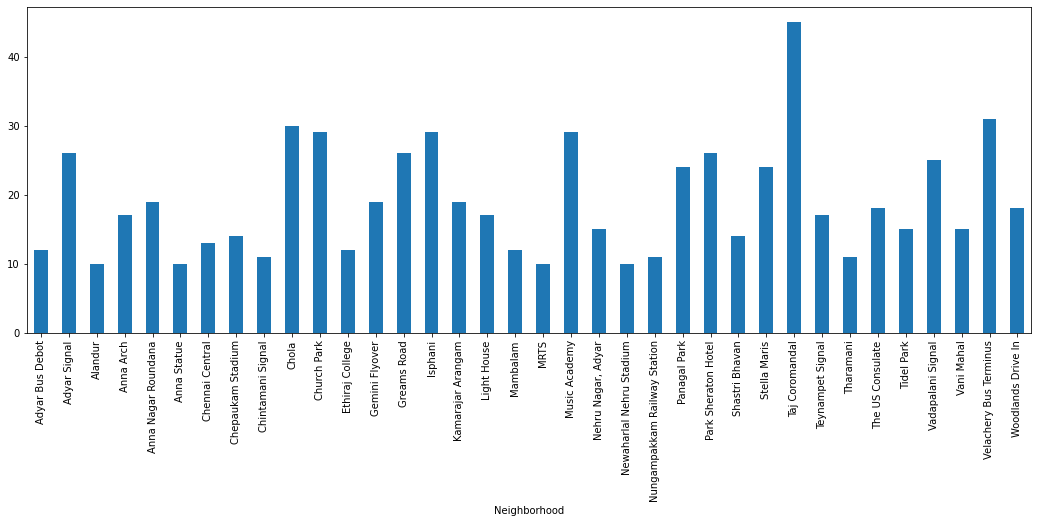

In [16]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, <b>chennai_venues_top </b>that contains only the <b>neighborhoods with 10+ venues </b> and the venues with their details included.

In [17]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Debot,12.997222,80.256944,Subway,12.999040,80.254743,Sandwich Place


<b>One hot encoding</b>

In [18]:
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(683, 96)


,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bistro,Bookstore,Boutique,Breakfast Spot,Bus Line,Bus Station,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Flea Market,Food,Food Court,Gaming Cafe,Garden,General Entertainment,Gym,Gym / Fitness Center,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Pub,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tea Room,Thai Restaurant,Theater,Track,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [19]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(36, 96)


,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bistro,Bookstore,Boutique,Breakfast Spot,Bus Line,Bus Station,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Flea Market,Food,Food Court,Gaming Cafe,Garden,General Entertainment,Gym,Gym / Fitness Center,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Pub,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tea Room,Thai Restaurant,Theater,Track,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.000000,0.0,0.166667,0.083333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar Signal,0.0,0.038462,0.0,0.000000,0.000000,0.076923,0.0,0.0,0.0,0.0,0.038462,0.0,0.000000,0.0,0.0,0.0,0.038462,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.000000,0.0,0.038462,0.0,0.0,0.038462,0.038462,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.384615,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.038462,0.0,0.000000,0.0,0.0,0.076923,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.000000,0.0,0.0,0.0,0.038462,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Alandur,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.1,0.0,0.0,0.000000,0.0,0.000000,0.1,0.2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.100000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0
3,Anna Arch,0.0,0.000000,0.0,0.000000,0.000000,0.058824,0.0,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.058824,0.0,0.0,0.176471,0.000000,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.058824,0.117647,0.0,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.117647,0.0,0.0,0.000000,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Anna Nagar Roundana,0.0,0.000000,0.0,0.052632,0.000000,0.000000,0.0,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,0.0,0.0,0.052632,0.0,0.0,0.105263,0.052632,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.052632,0.052632,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.263158,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.052632,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.05263

The following function returns the top_venues of each neighborhood.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe <b>neighborhoods_venues_sorted.</b>

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Café,BBQ Joint,Pizza Place,Sandwich Place,Middle Eastern Restaurant,Breakfast Spot,African Restaurant
1,Adyar Signal,Indian Restaurant,Coffee Shop,North Indian Restaurant,Bakery,Dessert Shop,Rock Club,Snack Place,Café,Electronics Store,Movie Theater
2,Alandur,Bus Station,Bus Line,Bar,South Indian Restaurant,Hotel Bar,Indian Restaurant,Hotel,Metro Station,Train,Multicuisine Indian Restaurant
3,Anna Arch,Clothing Store,Fast Food Restaurant,Multiplex,Sporting Goods Shop,Bookstore,Electronics Store,Pizza Place,Cosmetics Shop,Bakery,Food Court
4,Anna Nagar Roundana,Indian Restaurant,Clothing Store,Electronics Store,Paper / Office Supplies Store,Hotel Bar,Café,Fast Food Restaurant,South Indian Restaurant,Bookstore,Middle Eastern Restaurant


<b>Cluster Neighborhoods.</b>
Here k-Nearest Neighborhoods clustering technique is used. Lets use the <b>silhouette_score</b> to obtain the best value for the number of clusters.

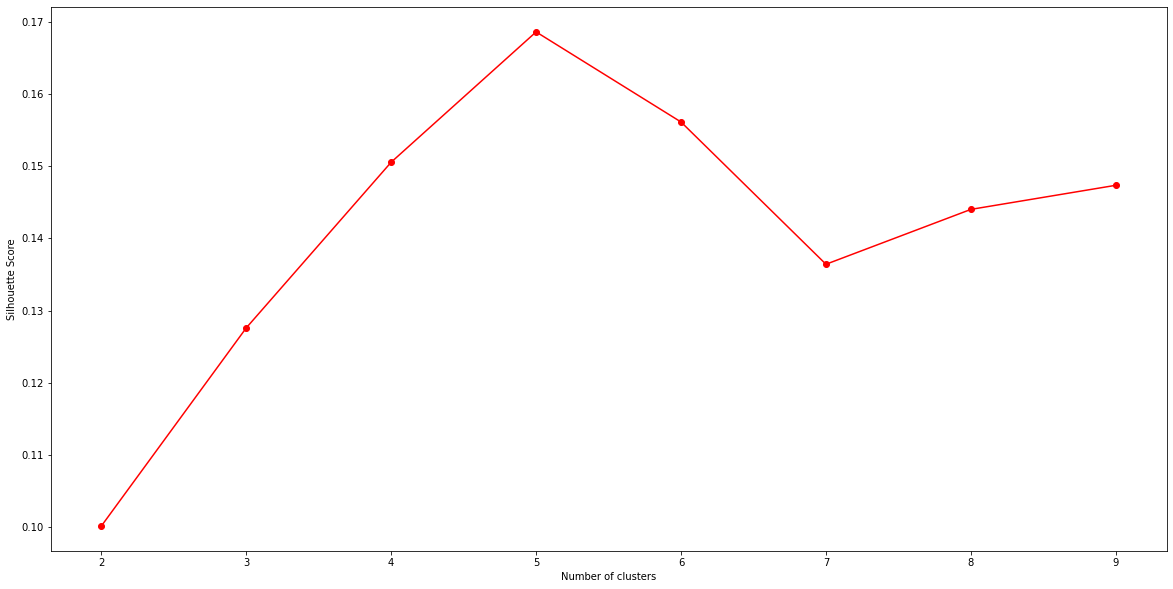

In [22]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 8. So, lets consider the number of clusters as 8.

In [23]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([0, 3, 5, 6, 3, 3, 2, 3, 8, 8], dtype=int32)

Add the cluster labels to the <b>neighborhoods_venues_sorted </b> dataframe. And lets create a new datframe <b> chennai_merged </b> which has the neighborhood details, cluster labels and the <b>10 most common venues</b> in that neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,0,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Café,BBQ Joint,Pizza Place,Sandwich Place,Middle Eastern Restaurant,Breakfast Spot,African Restaurant
1,Adyar Signal,13.006389,80.257500,3,Indian Restaurant,Coffee Shop,North Indian Restaurant,Bakery,Dessert Shop,Rock Club,Snack Place,Café,Electronics Store,Movie Theater
2,Alandur,13.007778,80.209722,5,Bus Station,Bus Line,Bar,South Indian Restaurant,Hotel Bar,Indian Restaurant,Hotel,Metro Station,Train,Multicuisine Indian Restaurant
3,Anna Arch,13.074444,80.218333,6,Clothing Store,Fast Food Restaurant,Multiplex,Sporting Goods Shop,Bookstore,Electronics Store,Pizza Place,Cosmetics Shop,Bakery,Food Court
4,Anna Nagar Roundana,13.084444,80.218056,3,Indian Restaurant,Clothing Store,Electronics Store,Paper / Office Supplies Store,Hotel Bar,Café,Fast Food Restaurant,South Indian Restaurant,Bookstore,Middle Eastern Restaurant


<h2><b>Results :</b></h2>

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

<b>Cluster 1 :</b>

In [25]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Café,BBQ Joint,Pizza Place,Sandwich Place,Middle Eastern Restaurant,Breakfast Spot,African Restaurant
29,Tharamani,Fast Food Restaurant,Hotel,Vegetarian / Vegan Restaurant,Asian Restaurant,Office,Food Court,Indian Restaurant,Sandwich Place,Café,Multiplex
31,Tidel Park,Fast Food Restaurant,Food Court,Café,Sandwich Place,Vegetarian / Vegan Restaurant,Bakery,Office,Indian Restaurant,Platform,African Restaurant


In [26]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Café                             3
Fast Food Restaurant             3
Sandwich Place                   3
Indian Restaurant                3
African Restaurant               2
Food Court                       2
Asian Restaurant                 2
Office                           2
Vegetarian / Vegan Restaurant    2
Middle Eastern Restaurant        1
dtype: int64


<b>Cluster 2 :</b>

In [27]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Church Park,Indian Restaurant,Movie Theater,Chinese Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Park,Gaming Cafe,Nightclub,Hotel,Multiplex
13,Greams Road,Movie Theater,Indian Restaurant,Café,Juice Bar,Chinese Restaurant,Middle Eastern Restaurant,Gaming Cafe,Multiplex,Mobile Phone Shop,Mexican Restaurant
18,MRTS,Indian Restaurant,Mobile Phone Shop,Women's Store,Pizza Place,Train Station,IT Services,Clothing Store,Chinese Restaurant,Multiplex,Park
20,"Nehru Nagar, Adyar",Café,Indian Restaurant,Pizza Place,Chinese Restaurant,Juice Bar,Thai Restaurant,Ice Cream Shop,Sandwich Place,Park,Paper / Office Supplies Store
22,Nungampakkam Railway Station,Women's Store,Mexican Restaurant,Clothing Store,Chinese Restaurant,South Indian Restaurant,Ice Cream Shop,Indian Restaurant,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant
27,Taj Coromandal,Indian Restaurant,Chinese Restaurant,Café,Sandwich Place,Italian Restaurant,Asian Restaurant,Electronics Store,Dessert Shop,Ice Cream Shop,Pizza Place
32,Vadapalani Signal,Indian Restaurant,South Indian Restaurant,Multiplex,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Bus Station,Pizza Place,Food Court,Hotel


In [28]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant     7
Chinese Restaurant    6
Pizza Place           5
Multiplex             4
Café                  3
Park                  3
Ice Cream Shop        3
Asian Restaurant      2
Juice Bar             2
Sandwich Place        2
dtype: int64


<b>Cluster 3 :</b>

In [29]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Chennai Central,Indian Restaurant,Platform,Train Station,Bookstore,Nightclub,Sandwich Place,Hotel,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Market
21,Newaharlal Nehru Stadium,Platform,Indian Restaurant,Bookstore,Sandwich Place,Soccer Stadium,Juice Bar,Vegetarian / Vegan Restaurant,Market,Multicuisine Indian Restaurant,Park


In [30]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Sandwich Place                   2
Market                           2
Bookstore                        2
Vegetarian / Vegan Restaurant    2
Indian Restaurant                2
Platform                         2
Mediterranean Restaurant         1
Park                             1
Hotel                            1
Juice Bar                        1
dtype: int64


<b>Cluster 4 :</b>

In [31]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adyar Signal,Indian Restaurant,Coffee Shop,North Indian Restaurant,Bakery,Dessert Shop,Rock Club,Snack Place,Café,Electronics Store,Movie Theater
4,Anna Nagar Roundana,Indian Restaurant,Clothing Store,Electronics Store,Paper / Office Supplies Store,Hotel Bar,Café,Fast Food Restaurant,South Indian Restaurant,Bookstore,Middle Eastern Restaurant
5,Anna Statue,Indian Restaurant,Multiplex,Dessert Shop,General Entertainment,Flea Market,Movie Theater,Pizza Place,Park,Paper / Office Supplies Store,Office
7,Chepaukam Stadium,Indian Restaurant,Café,Cafeteria,Mediterranean Restaurant,Hotel,General Entertainment,Bar,Multiplex,Bookstore,Nightclub
25,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Multicuisine Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Japanese Restaurant,Theater,Convenience Store,Coffee Shop
34,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Pizza Place,Clothing Store,Men's Store,Department Store,Gym,Coffee Shop,Shoe Store


In [32]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Indian Restaurant        6
Coffee Shop              3
Café                     3
Pizza Place              3
Fast Food Restaurant     3
Clothing Store           2
Movie Theater            2
Multiplex                2
General Entertainment    2
Bookstore                2
dtype: int64


<b>Cluster 5 :</b>

In [33]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Gemini Flyover,Hotel,Coffee Shop,Nightclub,Sandwich Place,Indian Restaurant,Chinese Restaurant,Café,South Indian Restaurant,Concert Hall,Thai Restaurant
14,Isphani,Indian Restaurant,Hotel,Pizza Place,Chinese Restaurant,Coffee Shop,Sandwich Place,Nightclub,South Indian Restaurant,Pub,Asian Restaurant
15,Kamarajar Arangam,Hotel,Café,Indian Restaurant,Clothing Store,South Indian Restaurant,Nightclub,Ice Cream Shop,Concert Hall,Bistro,Park
24,Park Sheraton Hotel,Café,Restaurant,Hotel,Thai Restaurant,Coffee Shop,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Nightclub,Department Store
30,The US Consulate,Hotel,Coffee Shop,Sandwich Place,Nightclub,Chinese Restaurant,Café,South Indian Restaurant,Indian Restaurant,Tea Room,Thai Restaurant
35,Woodlands Drive In,Hotel,Indian Restaurant,Chinese Restaurant,Nightclub,Concert Hall,Coffee Shop,Ice Cream Shop,South Indian Restaurant,Bar,Park


In [34]:

cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Indian Restaurant          6
Hotel                      6
South Indian Restaurant    6
Nightclub                  6
Coffee Shop                5
Chinese Restaurant         4
Café                       4
Thai Restaurant            3
Concert Hall               3
Sandwich Place             3
dtype: int64


<b>Cluster 6 :</b>

In [35]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alandur,Bus Station,Bus Line,Bar,South Indian Restaurant,Hotel Bar,Indian Restaurant,Hotel,Metro Station,Train,Multicuisine Indian Restaurant


In [36]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Multicuisine Indian Restaurant    1
Metro Station                     1
Train                             1
Bar                               1
Indian Restaurant                 1
South Indian Restaurant           1
Hotel                             1
Bus Station                       1
Bus Line                          1
Hotel Bar                         1
dtype: int64


<b>Cluster 7 :</b>

In [37]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Anna Arch,Clothing Store,Fast Food Restaurant,Multiplex,Sporting Goods Shop,Bookstore,Electronics Store,Pizza Place,Cosmetics Shop,Bakery,Food Court
16,Light House,Fast Food Restaurant,Coffee Shop,Department Store,Beach,Snack Place,Multiplex,Sandwich Place,Cosmetics Shop,Bar,American Restaurant


In [38]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Multiplex               2
Fast Food Restaurant    2
Cosmetics Shop          2
Clothing Store          1
Bookstore               1
Beach                   1
Coffee Shop             1
Sporting Goods Shop     1
Pizza Place             1
Food Court              1
dtype: int64


<b>Cluster 8 :</b>

In [39]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Mambalam,Clothing Store,Indian Restaurant,Jewelry Store,Asian Restaurant,Concert Hall,Boutique,South Indian Restaurant,Multiplex,Pizza Place,Park
23,Panagal Park,Indian Restaurant,Clothing Store,Jewelry Store,South Indian Restaurant,Boutique,Vegetarian / Vegan Restaurant,Pizza Place,Dessert Shop,Concert Hall,Coffee Shop


In [40]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Clothing Store                   2
Boutique                         2
Concert Hall                     2
South Indian Restaurant          2
Pizza Place                      2
Jewelry Store                    2
Indian Restaurant                2
Park                             1
Vegetarian / Vegan Restaurant    1
Coffee Shop                      1
dtype: int64


<h2><b>Discussion .</b></h2>

Lets visulaize the top 5 most common venue categories in each of the cluster.

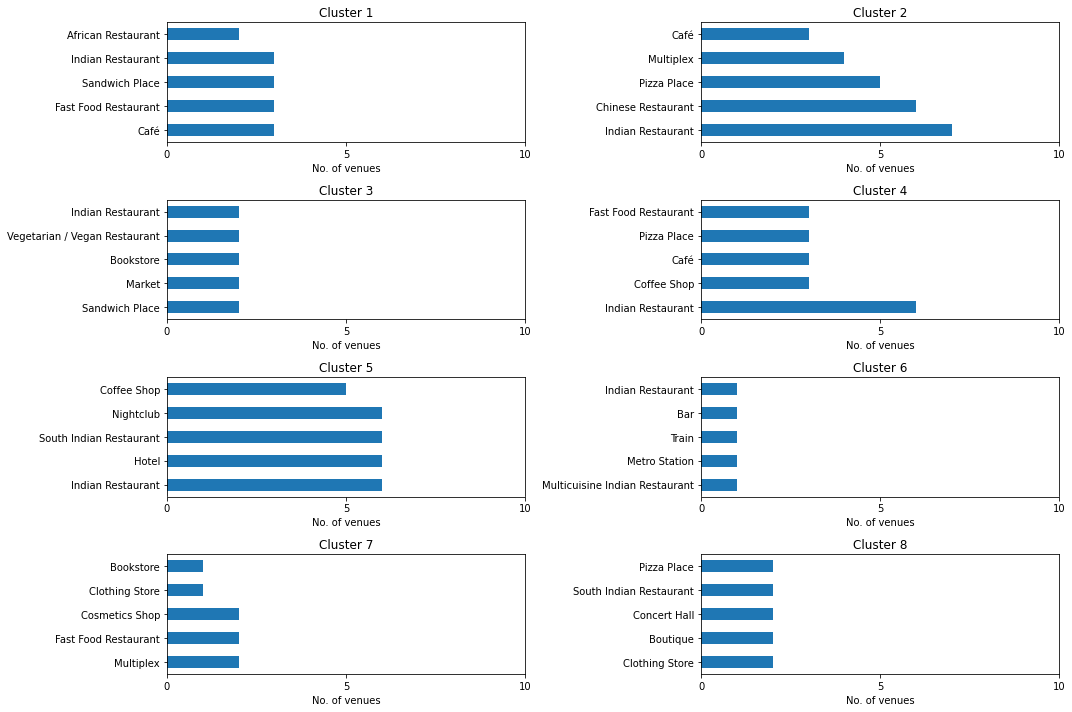

In [41]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

<b>1. Indian Restaurant </b>

The neighborhoods in cluster 2 & 4has the greatest number of Indian Restaurant, hence opening one here is not the best choice. So, is it best to open one at the neighborhoods in cluster 7 or 8? Not likely, since the place has a smaller number of food restaurants. Thus, an optimal place would be one which has less Indian Restaurant, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 7 and Cluster 6. such as the Adyar Bus Depot, Triplicane neighborhoods.

<b>2. pizza place </b>

The neighborhoods 2 has notable number of pizza place. By using the same procedure as above, the suitable cluster would be the Cluster3 and Cluster 7, since it has not much shopping malls and also it has many Hotels and Restaurants which gives an advantage.

Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.

<b>Map of Chennai with the clusters superimposed on top. </b>

In [42]:
# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

This map can also be used to select a vast suggestion area for a particular type of business based on the category.

<h2><b>Conclusion .</b></h2>

Purpose of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

<h2><b>Thank you.</b></h2>

I hope you found the project useful and interesting. Feel free to contact me if you have any queries or suggestions.

This notebook was developed by mesurajghotkar.